In [1]:
import gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel
%config InlineBackend.figure_formats = ['svg']

In [2]:
torch.cuda.is_available()

False

In [3]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [4]:
buffer_size = 1000

env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=0,
                   sample_pars=False,
                   log_reward=False,
                   rand_start=True,
                   relax_time=45,
                   tpa_in_state=True,
                   pars={'store_raw': False,
                         'max_buffer_len': buffer_size,
                         'tpa_queue': [10],
                         'pileup_prob': 0.,
                         'xi': np.array([1e2]),
                         'tau': np.array([45]), 
                         'tp_interval': 10},
               render_mode='human',
                   )

In [5]:
obs, info = env.reset()

In [6]:
world_model = CryoWorldModel()

In [26]:
torch.sigmoid(world_model.curiosity_network(torch.rand(16,4)*2-1))

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward0>)

In [22]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=3e-4, buffer_size=buffer_size, learning_starts=0,
                        batch_size=16, gamma=.9, gradient_steps=5, grad_clipping=.5, tau=0.005, model_steps=15, world_model=world_model,
                        device='cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [24]:
model.learn(episodes = 1, 
            episode_steps = 40, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
world_model.get_reward()

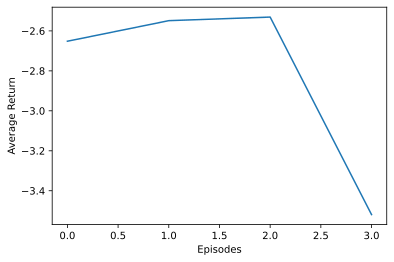

In [10]:
tracker.plot(smooth=1)

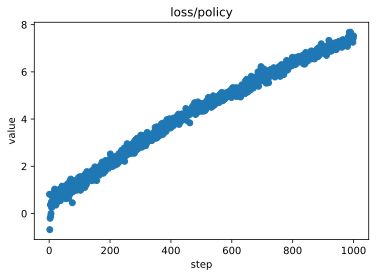

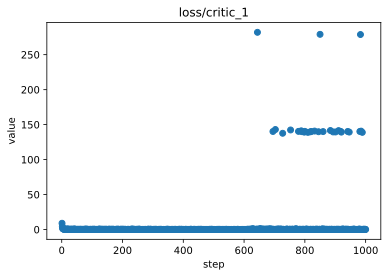

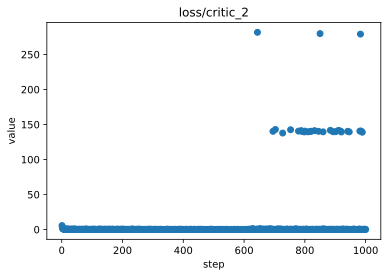

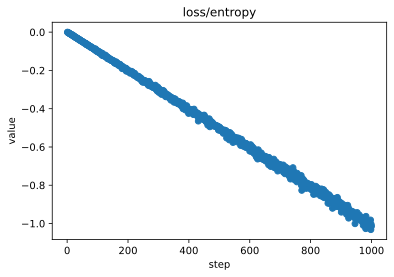

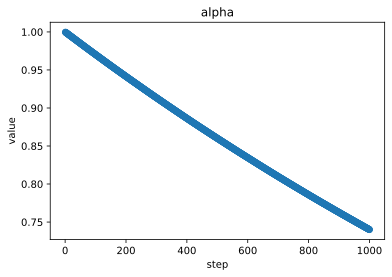

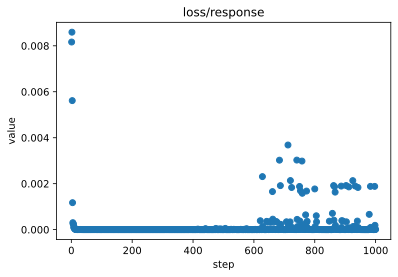

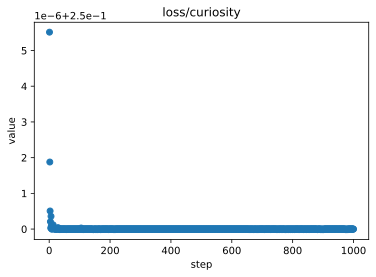

In [11]:
for key in writer.history.keys():
    writer.plot(key)

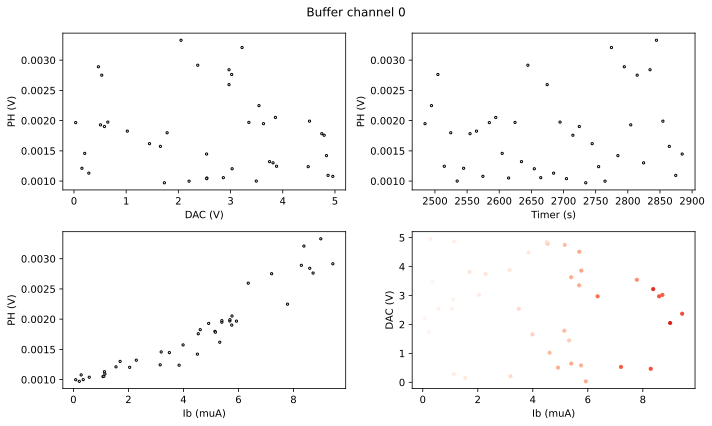

In [12]:
env.detector.plot_buffer()

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 0.0411373  -0.08241338]]
[-0.99993877 -0.99998305 -0.08241338  0.04113734  3.          0.81715931
 -0.57409684] -2.768348722732374


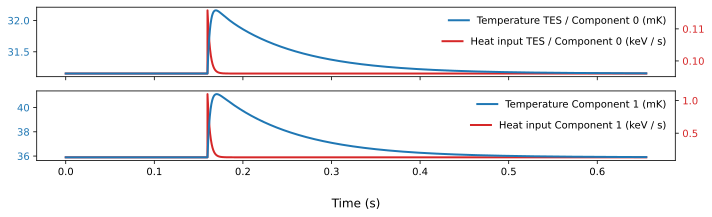

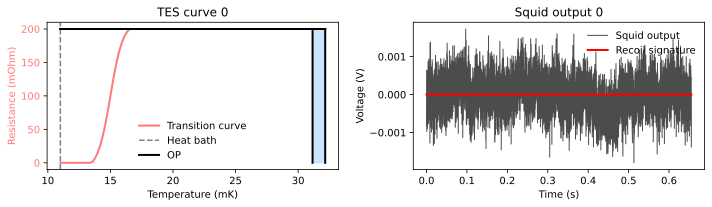

[[ 0.03447499 -0.07337176]]
[-0.99991966 -0.99998267 -0.07337177  0.03447497  3.          0.66895027
 -0.46657039] -2.1574937990227974


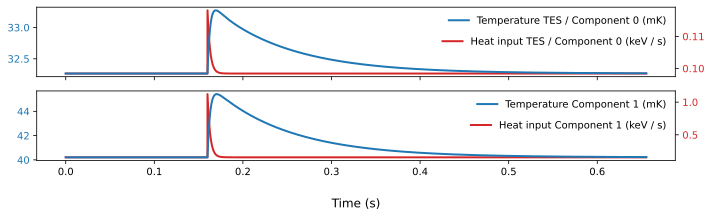

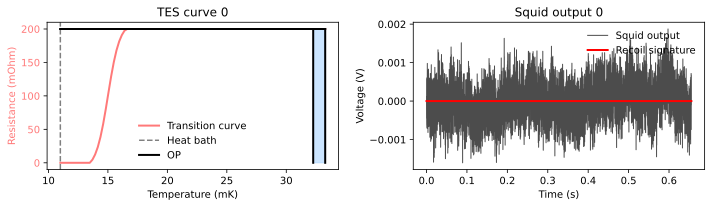

[[ 0.03704041 -0.0719173 ]]
[-0.99993465 -0.99998275 -0.07191736  0.03704035  3.          0.54998394
 -0.38098112] -2.639429379633606


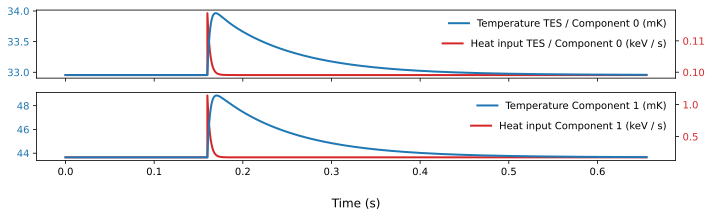

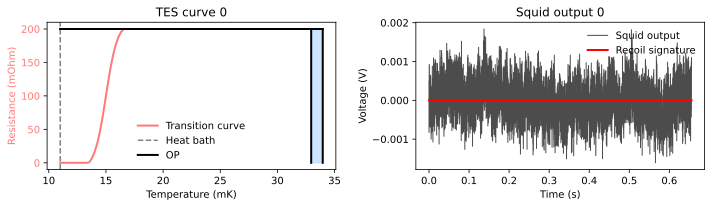

[[ 0.03901997 -0.07048246]]
[-0.99993752 -0.99998223 -0.07048243  0.03901994  3.          0.45443723
 -0.31284105] -2.8441763038116776


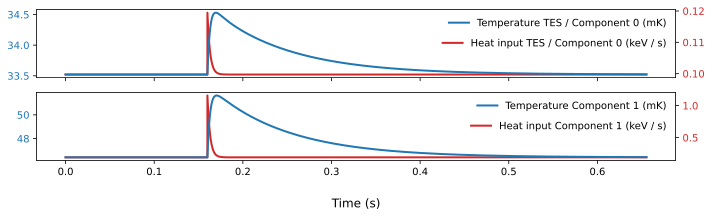

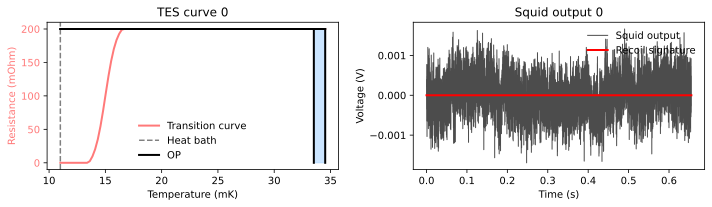

[[ 0.04059826 -0.0691103 ]]
[-0.99994552 -0.99998265 -0.06911027  0.04059827  3.          0.37765598
 -0.25859324] -3.18438111692164


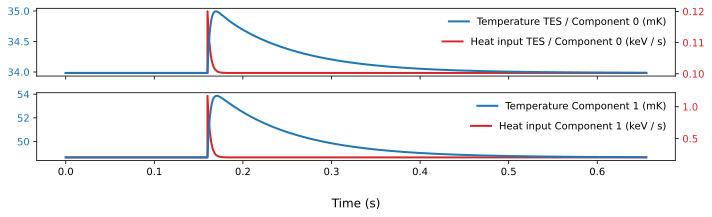

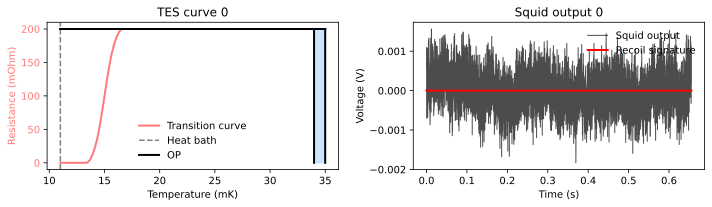

[[ 0.04186277 -0.06801035]]
[-0.99994055 -0.99998303 -0.06801033  0.04186273  3.          0.31595518
 -0.21540696] -2.8543120495898866


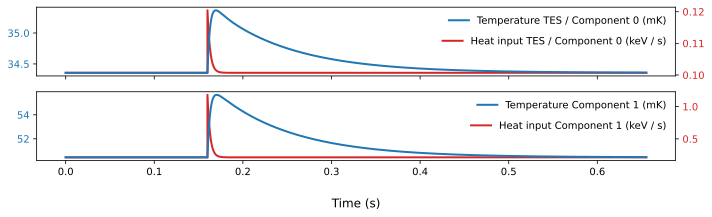

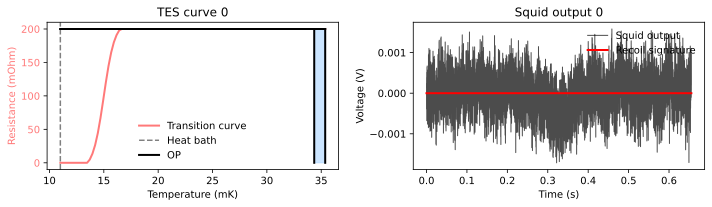

[[ 0.042854   -0.06707362]]
[-0.99992586 -0.99998278 -0.06707364  0.04285395  3.          0.2663624
 -0.1810236 ] -2.3221327764337696


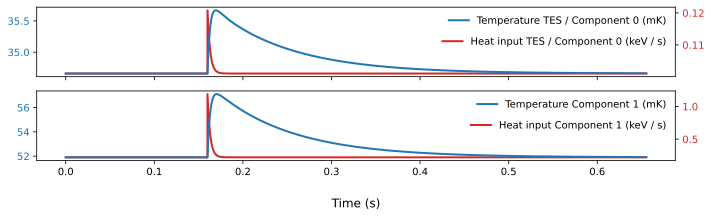

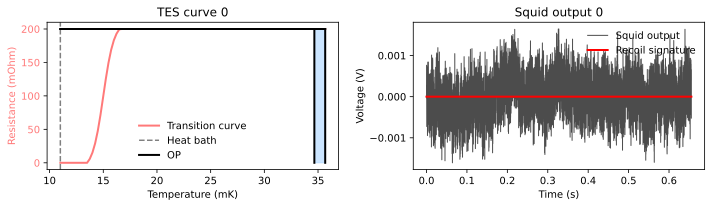

[[ 0.04361392 -0.06628229]]
[-0.99993789 -0.99998302 -0.06628227  0.04361391  3.          0.22649391
 -0.15364299] -2.7333525601664967


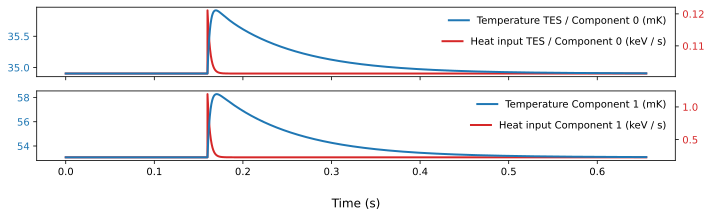

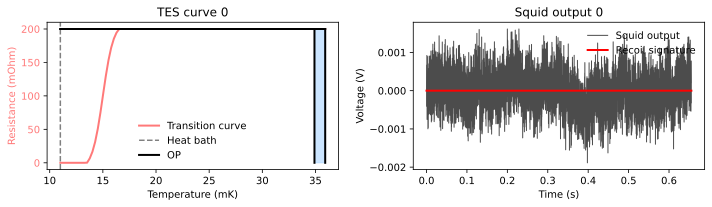

[[ 0.04422416 -0.06564793]]
[-0.99993039 -0.9999819  -0.06564796  0.04422414  3.          0.19444333
 -0.1318399 ] -2.600015963634285


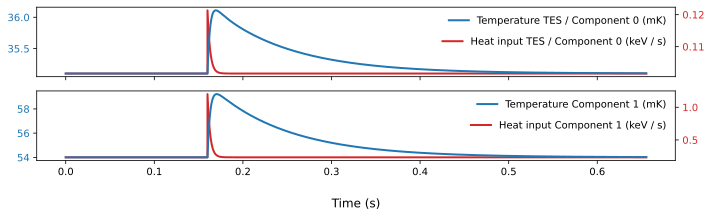

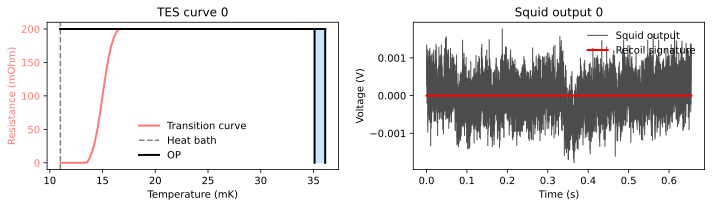

[[ 0.04471979 -0.06513086]]
[-0.9999207  -0.99998241 -0.06513083  0.04471982  3.          0.16867619
 -0.11448013] -2.2183093391751574


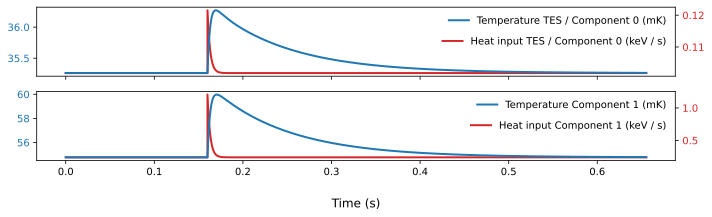

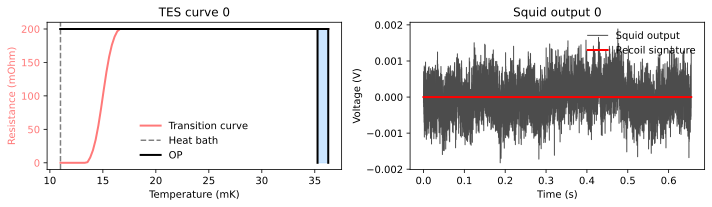

In [13]:
obs, _ = env.reset()
model.policy.eval()
returns = 0
for i in trange(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    print(action)
    print(obs, reward)
    returns += reward
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

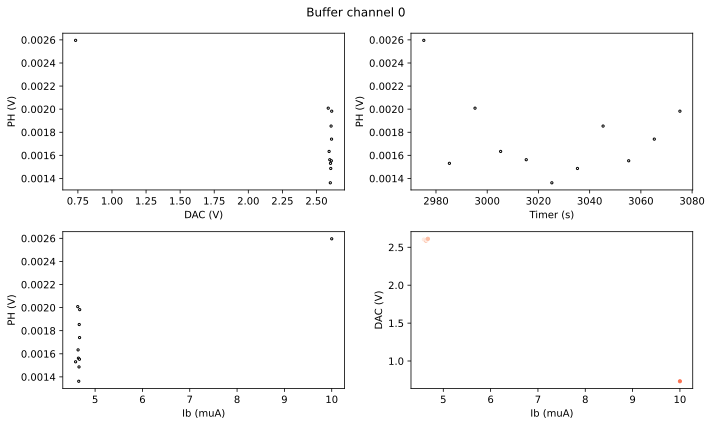

In [14]:
env.detector.plot_buffer()

In [15]:
# env.close()

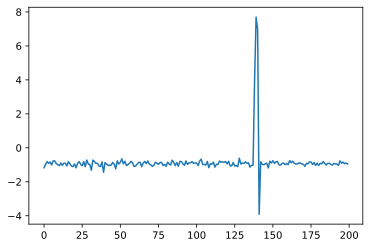

In [16]:
plt.plot(- np.log(- model.buffer.reward_memory[:200]))

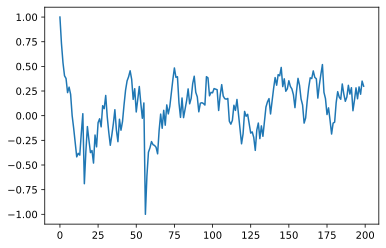

In [18]:
plt.plot(model.buffer.state_memory[:200,5])